# Machine Learning. Feature Selection

## Task Description

Identify three important features using two different approaches.

Train a regression model using the identified three features and compare the results.

## Import Necessary Libraries

In [89]:
import pandas as pd
import plotly.express as px
import sys

from sklearn import linear_model
from sklearn import model_selection
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE 
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import OneHotEncoder

sys.path.append('../../')

## Load Data

In [90]:
data = pd.read_excel('../../data/data_ford_price.xlsx')
data

,price,year,condition,cylinders,odometer,title_status,transmission,drive,size,lat,long,weather
0,43900,2016,4,6,43500,clean,automatic,4wd,full-size,36.471500,-82.483400,59.0
1,15490,2009,2,8,98131,clean,automatic,4wd,full-size,40.468826,-74.281734,52.0
2,2495,2002,2,8,201803,clean,automatic,4wd,full-size,42.477134,-82.949564,45.0
3,1300,2000,1,8,170305,rebuilt,automatic,4wd,full-size,40.764373,-82.349503,49.0
4,13865,2010,3,8,166062,clean,automatic,4wd,NaN,49.210949,-123.114720,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
7012,22500,2015,3,6,23500,clean,automatic,rwd,full-size,32.680700,-117.169800,59.0
7013,5975,2005,2,8,0,clean,automatic,rwd,full-size,38.213303,-85.785762,50.0
7014,9999,2006,3,8,161514,clean,automatic,NaN,full-size,37.609783,-120.995406,59.0
7015,10900,2011,2,8,164000,clean,automatic,4wd,full-size,43.140600,-93.385000,47.0


## Data Cleaning and Preprocessing

For the sake of simplicity I will not perform any extensive data cleaning, but will just remove the empty values to let the models generate without errors.

In [91]:
data.dropna(inplace=True)

As next I will encode categorical features 'title_status', 'transmission', 'drive' and 'size'.

In [92]:
print('Number of values in \'title_status\'', len(data['title_status'].value_counts()))
print('Number of values in \'transmission\'', len(data['transmission'].value_counts()))
print('Number of values in \'drive\'', len(data['drive'].value_counts()))
print('Number of values in \'size\'', len(data['size'].value_counts()))

Number of values in 'title_status' 5
Number of values in 'transmission' 3
Number of values in 'drive' 3
Number of values in 'size' 4


All four features can be encoded using a one-hot encoder.

In [93]:
cat_cols = ['title_status', 'transmission', 'drive', 'size']
encoder = OneHotEncoder()
encoded = encoder.fit_transform(data[cat_cols]).toarray()
data[encoder.get_feature_names_out(cat_cols)] = encoded
data.drop(cat_cols, axis=1, inplace=True)

In [94]:
corr = data.corr()
corr = corr[((corr >= 0.7) | (corr <= -0.7))]

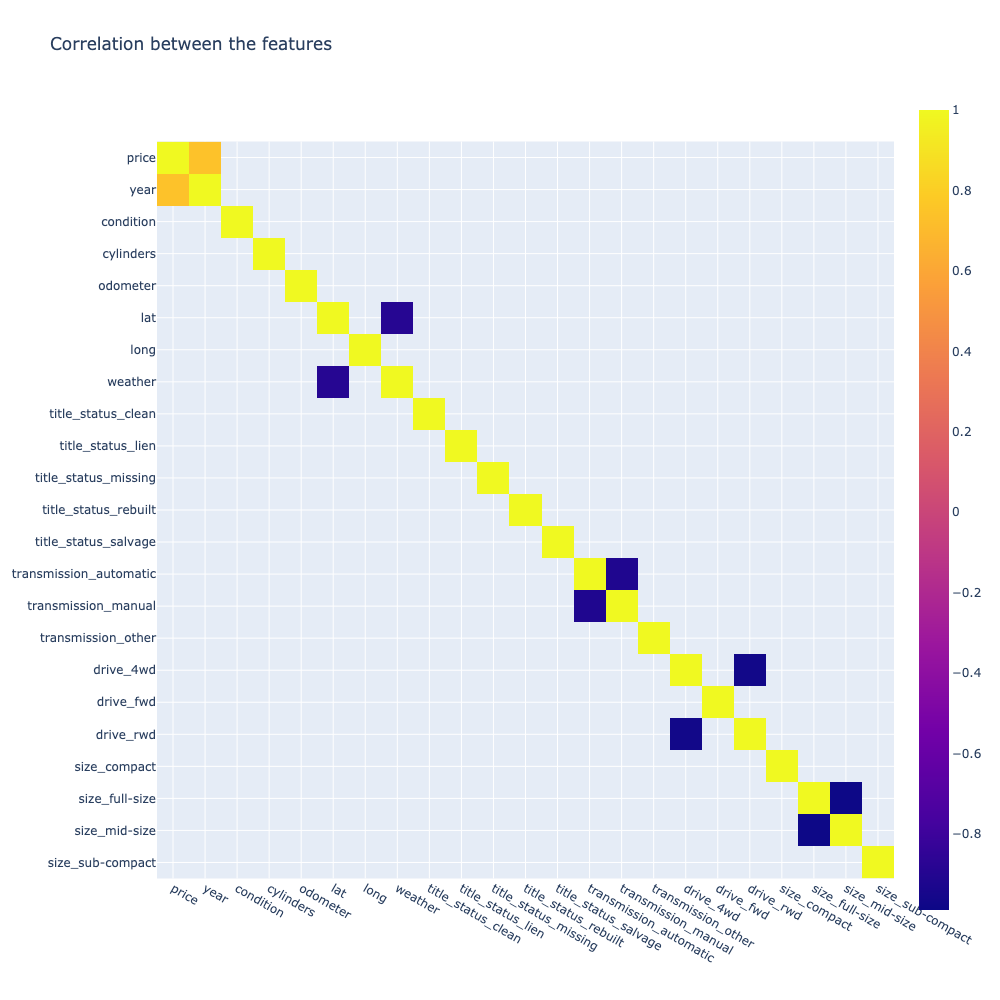

In [95]:
px.imshow(
    corr,
    width=1000,
    height=1000,
    title='Correlation between the features'
).show('png')

The following pairs of features have a correlation greater than or equal to 0.7 or less than or equal to -0.7:
* 'year' and 'price': keep the 'price' as our target feature and remove 'year'
* 'weather' and 'lat': keep the 'lat' as a complement to 'long'
* 'drive_rwd' and 'drive_4wd': keep the 'drive_4wd' (here and below keep the bigger option)
* 'size_mid-size' and 'size_full-size': keep the 'size_full-size' 

In [96]:
data = data.drop(['year', 'weather', 'drive_rwd', 'size_mid-size'], axis=1)

Split the data into train and test datasets.

In [97]:
X = data.drop('price', axis=1)
y = data['price']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

## Identify Important Features

### Recursive Feature Elimination (RFE)

In [98]:
estimator = linear_model.LinearRegression()
selector = RFE(estimator, n_features_to_select=3, step=1)
selector = selector.fit(X_train, y_train)

print('Identified important features:', selector.get_feature_names_out())

Identified important features: ['transmission_automatic' 'transmission_manual' 'transmission_other']


### Filter-based Feature Selection

In [99]:
selector = SelectKBest(f_classif, k=3)
selector.fit(X_train, y_train)

print('Identified important features:', selector.get_feature_names_out())

Identified important features: ['condition' 'odometer' 'size_full-size']


## Train Models with Important Features